# Persistence Module Decomposition (AIDA)

**Note.** This is a work in progress. Interface may change in the future, and feedbacks are welcome. Features are also missing (e.g., intervals identifiability) for the moment.

This notebook shows how to decompose a multiparameter persistence module, represented by a minimal presentation, into a direct sum of indecomposable summands.

The theory can be found in [Decomposing Multiparameter Persistence Modules](https://doi.org/10.4230/LIPIcs.SoCG.2025.41), and the code [here](https://doi.org/10.4230/artifacts.23282).

In [1]:
import numpy as np
from multipers.ops import aida
import matplotlib.pyplot as plt
import multipers as mp
import os
from os.path import expanduser
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


## Toy examples

TODO

The two following modules are usually used to show that two modules may have the same rank invariant, 
while not being isomorphic.

The first module is decomposable into two interval modules, 
while the second is indecomposable.

In [2]:
presentation1 = [[],[],[],[0,1],[0],[1],[2],[2],]
dimension1 = [0,0,0,1,1,1,1,1]
filtration_values1 = [[1,0],[0,1],[1,1],[1,1],[3,0],[0,3],[2,1],[1,2]]

presentation2 = [[],[],[0],[1],[0,1], [0,1]]
dimension2 = [0,0,1,1,1,1]
filtration_values2 = [[1,0],[0,1],[3,0],[0,3],[2,1], [1,2]]

s1 = mp.Slicer(return_type_only=True, vineyard=True)(
    presentation1, dimension1, filtration_values1
).minpres(0).to_colexical()
s2 = mp.Slicer(return_type_only=True, vineyard=True)(
    presentation2, dimension2, filtration_values2
).minpres(0).to_colexical()


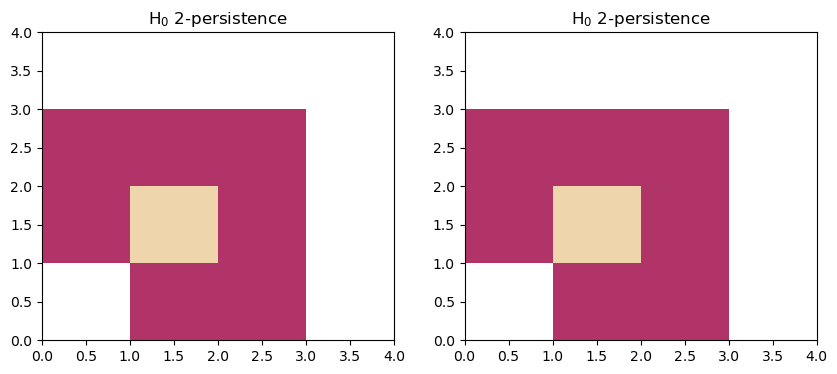

In [3]:
fig, (a,b) = plt.subplots(ncols=2, figsize=(10,4))
box=[[0,0],[4,4]]
plt.sca(a)
mp.module_approximation(s1, box=box).plot(0)
plt.sca(b)
mp.module_approximation(s2, box=box).plot(0)

We can use AIDA to confirm this decomposition:

In [4]:
I1,I2 = mp.ops.aida(s1) # the two rectangles

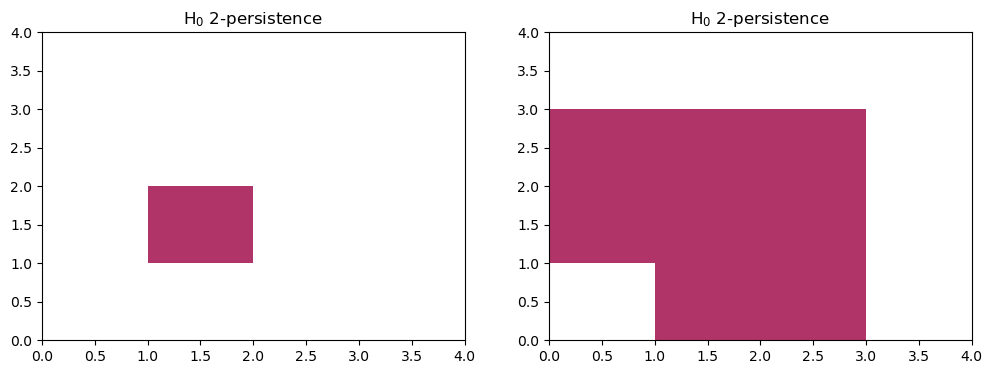

In [5]:
fig, (a,b) = plt.subplots(ncols=2, figsize=(12,4))
plt.sca(a)
mp.module_approximation(I1, box=box).plot(0)
plt.sca(b)
mp.module_approximation(I2, box=box).plot(0)

In [6]:
indec,  = mp.ops.aida(s2) # the indecomposable
s2.prune_above_dimension(1).to_colexical() == indec.to_colexical()

True

## Application

The vast majority of invariants are additive. In particular, computing such invariants can be achieved by computing them on the individual summands and summing them. 
As the majority of these computations are supra-linear, they can be much more efficiently that way.

The dataset can be found [here](https://github.com/MultiparameterTDAHistology/SpatialPatterningOfImmuneCells).

In [7]:
def get_immuno(i, DATASET_PATH="./"):
    immu_dataset = read_csv(DATASET_PATH+f"LargeHypoxicRegion{i}.csv")
    X = np.array(immu_dataset['x'])
    X /= np.max(X)
    Y = np.asarray(immu_dataset['y'])
    Y /= np.max(Y)
    labels = LabelEncoder().fit_transform(immu_dataset['Celltype'])
    return np.concatenate([X[:,None], Y[:,None]], axis=1), labels
x, y = get_immuno(1)
x = x[y==0]

We start by computing a minimal presentation of a multiparameter persistence module,
here the degree one homology of a DelaunayCodensity bifiltration of a immunohistochemistry dataset.

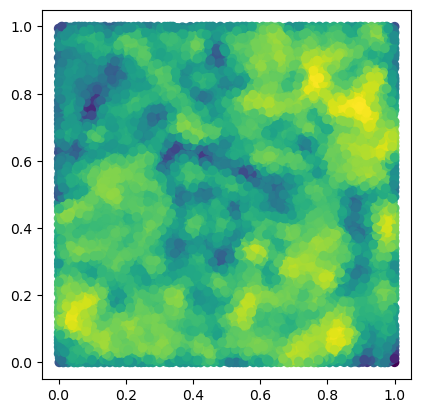

In [8]:
from multipers.filtrations.density import KDE
from fpsample import bucket_fps_kdline_sampling as fpsample
bandwidth=.02
n = 10_000
degree = 1
y = np.random.uniform(0,1, (100*n,2))
y = y[fpsample(y, n, 7)]
f = KDE(bandwidth=bandwidth, return_log=True).fit(x).score_samples(y)
plt.scatter(*y.T, c=f)
plt.gca().set_aspect(1)
plt.show()
s = mp.filtrations.DelaunayLowerstar(points=y, function=-f, reduce_degree=degree)

On which we compute the module decomposition

In [9]:
print(len(s))
out = aida(s, progress=True)

66074
33037 batches : [##################################################] 100%


Note that the vast majority of the indecomposable summands are very small

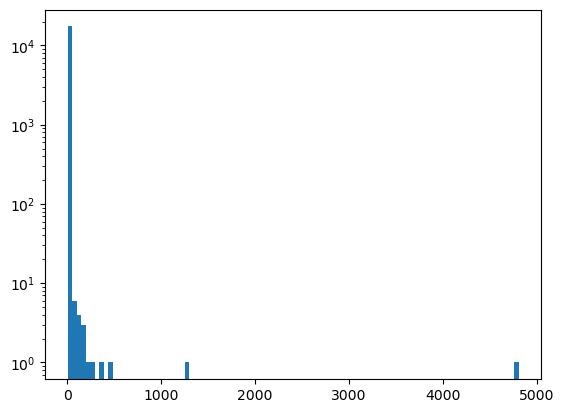

In [33]:
plt.hist([len(x) for x in out], bins=100)
plt.gca().set_yscale("log")

The most striking example of efficiency gains is computing the signed barcodes, which scales with the size of the grid, and hence vastly benefits from such strategy, as individual subgrids can be used for each summands.

In [11]:
from joblib import Parallel,delayed
max_res = 200 # upper threshold

# parallel computation of the signed barcodes of each summands
# TODO : optimize parallelization
sms = Parallel(n_jobs=-1, backend="threading")(delayed(
    lambda x : mp.signed_measure(
        (x.grid_squeeze(resolution=max_res, strategy="regular_closest") if len(x)>max_res else x), 
        degree=degree, 
        invariant="rectangle"
    )[0])(x) for x in out)

# Signed barcodes are additive invariants
sm = mp.point_measure.add_sms(sms)

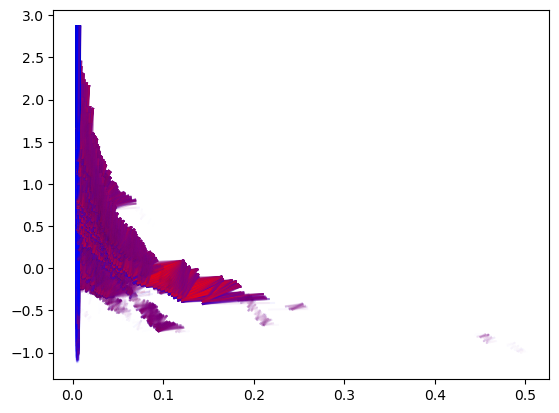

In [12]:
mp.plots.plot_signed_measure(sm)

In [13]:
# Todo : multiple at the same time
mp.point_measure.barcode_from_rank_sm(sm, basepoint=[0,1],direction=[1,1])

array([[0.00378137, 0.00435642],
       [0.00382541, 0.0043549 ],
       [0.00383778, 0.00438226],
       ...,
       [0.02079793, 0.02737336],
       [0.02510299, 0.02625465],
       [0.02510299, 0.02625465]], shape=(15440, 2))

Similarly, MMA decompositions can be obtained following this strategy

In [14]:
# MMA in parallel (TODO : optimize parallel)
from joblib import Parallel, delayed
mmas = Parallel(n_jobs=-1, backend="threading")(delayed(
    lambda x : mp.module_approximation(x).get_module_of_degree(degree)
)(stuff) for stuff in out)
mma_ = type(mmas[0])()._add_mmas(mmas)
if len(mma_):
    num_parameters = mma_[0].num_parameters()
    mma_.set_box([[0]*num_parameters,[1]*num_parameters])
    mma_.set_box(mp.grids.compute_bounding_box(mma_))

/var/folders/w6/5k5w13s94bq0dfsx2xzqxcsh0000gn/T/ipykernel_25146/1782830220.py:4: UserWarning: Got (box[1] == box[0])=array([False,  True]) trivial box coordinates.
  lambda x : mp.module_approximation(x).get_module_of_degree(degree)
/var/folders/w6/5k5w13s94bq0dfsx2xzqxcsh0000gn/T/ipykernel_25146/1782830220.py:4: UserWarning: (copy warning) Got a non-vine slicer as an input. Use `vineyard=True` to remove this copy.
  lambda x : mp.module_approximation(x).get_module_of_degree(degree)


In [15]:
# For colors in the plot
p = np.argsort([summand.get_birth_list()[0][1] for summand in mma_])
mma_ = mma_.permute_summands(p)
p = np.argsort([summand.get_birth_list()[0][0] for summand in mma_])
mma_ = mma_.permute_summands(p)

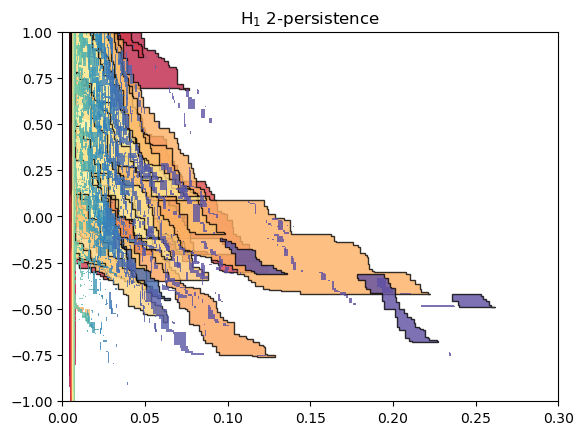

In [16]:
mma_.plot(outline_threshold=.01, outline_width=1, box = [[0,-1],[.3,1]])